In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Ignore everything above

In [3]:
# from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
# Creates a series of lookback windows to be used for training and predicting window t+1
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:
pm_df = pd.read_csv('./split_0_8765.csv')
timeseries = pm_df[['Sample Measurement']].values.astype('float32')
train_size = int(len(timeseries) * 0.75)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
train.shape, test.shape

((6574, 1), (2192, 1))

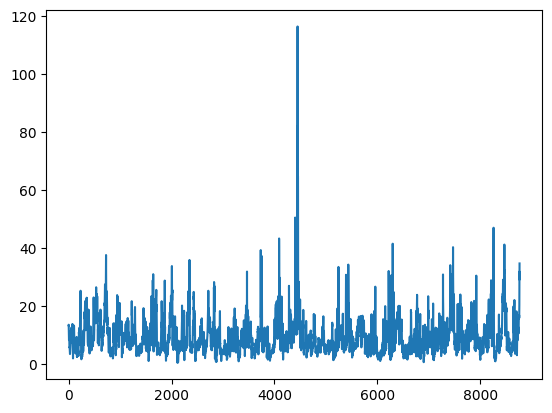

In [6]:
plt.plot(timeseries)

In [7]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([6567, 7, 1]) torch.Size([6567, 7, 1])
torch.Size([2185, 7, 1]) torch.Size([2185, 7, 1])


<ipython-input-3-441be4e99ef4>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


In [8]:
class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [9]:
import torch.optim as optim
import torch.utils.data as data

model = LSTM_Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 2.9973, test RMSE 2.8445
Epoch 1: train RMSE 2.6689, test RMSE 2.3305
Epoch 2: train RMSE 2.4779, test RMSE 2.0724
Epoch 3: train RMSE 2.4498, test RMSE 2.0738
Epoch 4: train RMSE 2.3431, test RMSE 1.9648
Epoch 5: train RMSE 2.3084, test RMSE 1.9570
Epoch 6: train RMSE 2.2893, test RMSE 1.9964
Epoch 7: train RMSE 2.2785, test RMSE 2.0061
Epoch 8: train RMSE 2.2341, test RMSE 1.9492
Epoch 9: train RMSE 2.2112, test RMSE 1.9670
Epoch 10: train RMSE 2.2069, test RMSE 1.9967
Epoch 11: train RMSE 2.1853, test RMSE 1.9714
Epoch 12: train RMSE 2.1617, test RMSE 1.9170
Epoch 13: train RMSE 2.1707, test RMSE 1.9527
Epoch 14: train RMSE 2.1447, test RMSE 1.9780
Epoch 15: train RMSE 2.1314, test RMSE 1.9245
Epoch 16: train RMSE 2.2373, test RMSE 2.1614
Epoch 17: train RMSE 2.1266, test RMSE 1.9754
Epoch 18: train RMSE 2.1069, test RMSE 1.9552
Epoch 19: train RMSE 2.1241, test RMSE 1.9482
Epoch 20: train RMSE 2.1059, test RMSE 1.9348
Epoch 21: train RMSE 2.0831, test RMSE 1.975

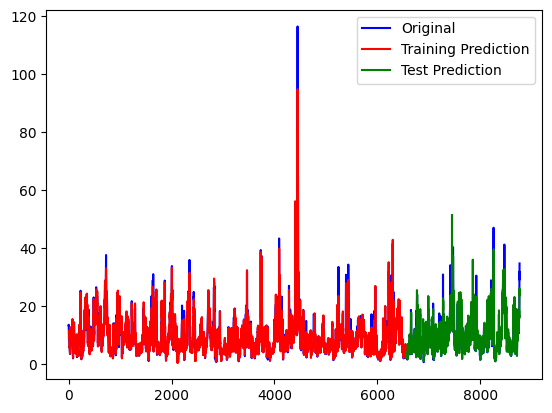

In [12]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b', label="Original")
plt.plot(train_plot, c='r', label="Training Prediction")
plt.plot(test_plot, c='g', label="Test Prediction")
plt.legend()
#plt.xlim(7250, 7750)
plt.show()

In [15]:
pm10_df = pd.read_csv('cleaned_MKE_2020_pm10.csv')
timeseries = pm10_df[['Sample Measurement']].values.astype('float32')
train_size = int(len(timeseries) * 0.75)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
train.shape, test.shape

((6491, 1), (2164, 1))

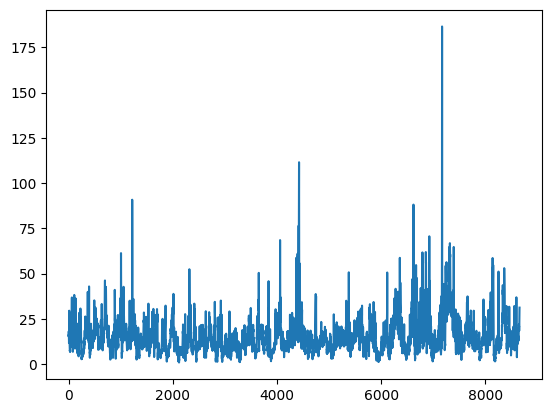

In [16]:
plt.plot(timeseries)

In [41]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([6484, 7, 1]) torch.Size([6484, 7, 1])
torch.Size([2157, 7, 1]) torch.Size([2157, 7, 1])


In [45]:
import torch.optim as optim
import torch.utils.data as data

model = LSTM_Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 4.6486, test RMSE 9.7749
Epoch 1: train RMSE 4.0044, test RMSE 8.1149
Epoch 2: train RMSE 3.7657, test RMSE 7.2883
Epoch 3: train RMSE 3.5985, test RMSE 6.8289
Epoch 4: train RMSE 3.4918, test RMSE 6.4340
Epoch 5: train RMSE 3.4437, test RMSE 6.1666
Epoch 6: train RMSE 3.3653, test RMSE 5.9984
Epoch 7: train RMSE 3.2968, test RMSE 5.9121
Epoch 8: train RMSE 3.2644, test RMSE 5.6865
Epoch 9: train RMSE 3.2283, test RMSE 5.8448
Epoch 10: train RMSE 3.2529, test RMSE 5.7501
Epoch 11: train RMSE 3.1283, test RMSE 5.6484
Epoch 12: train RMSE 3.1532, test RMSE 5.8165
Epoch 13: train RMSE 3.2052, test RMSE 5.8371
Epoch 14: train RMSE 3.0803, test RMSE 5.6184
Epoch 15: train RMSE 3.1153, test RMSE 5.8595
Epoch 16: train RMSE 3.0792, test RMSE 5.8069
Epoch 17: train RMSE 3.0511, test RMSE 5.7331
Epoch 18: train RMSE 3.0955, test RMSE 5.8715
Epoch 19: train RMSE 3.0071, test RMSE 5.8442
Epoch 20: train RMSE 3.0036, test RMSE 5.6722
Epoch 21: train RMSE 2.9771, test RMSE 5.553

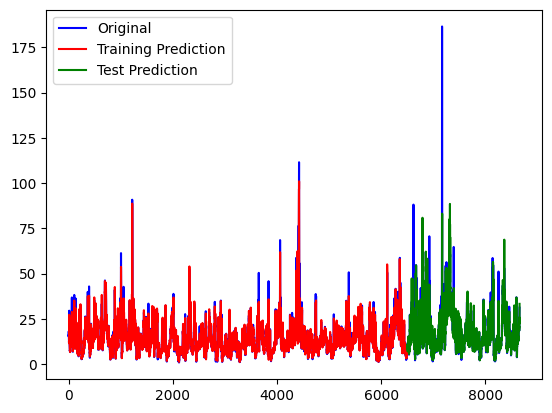

In [46]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b', label="Original")
plt.plot(train_plot, c='r', label="Training Prediction")
plt.plot(test_plot, c='g', label="Test Prediction")
plt.legend()
#plt.xlim(7250, 7750)
plt.show()

In [29]:
so2_df = pd.read_csv('cleaned_MKE_2020_so2.csv')
timeseries = so2_df[['Sample Measurement']].values.astype('float32')
train_size = int(len(timeseries) * 0.75)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
train.shape, test.shape

((6193, 1), (2065, 1))

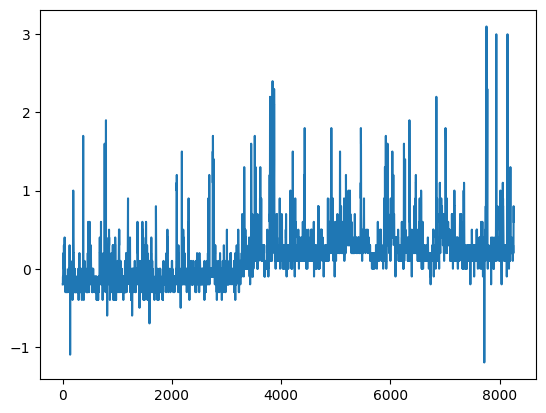

In [30]:
plt.plot(timeseries)

In [35]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([6484, 7, 1]) torch.Size([6484, 7, 1])
torch.Size([2157, 7, 1]) torch.Size([2157, 7, 1])


In [39]:
import torch.optim as optim
import torch.utils.data as data

model = LSTM_Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 4.8070, test RMSE 10.0927
Epoch 1: train RMSE 4.0278, test RMSE 8.2449
Epoch 2: train RMSE 3.7700, test RMSE 7.4028
Epoch 3: train RMSE 3.6131, test RMSE 6.8611
Epoch 4: train RMSE 3.4969, test RMSE 6.4567
Epoch 5: train RMSE 3.4453, test RMSE 6.2405
Epoch 6: train RMSE 3.3671, test RMSE 5.9305
Epoch 7: train RMSE 3.3723, test RMSE 5.8912
Epoch 8: train RMSE 3.2821, test RMSE 5.9563
Epoch 9: train RMSE 3.2580, test RMSE 5.8321
Epoch 10: train RMSE 3.1759, test RMSE 5.7083
Epoch 11: train RMSE 3.1549, test RMSE 5.7118
Epoch 12: train RMSE 3.1295, test RMSE 5.5983
Epoch 13: train RMSE 3.1229, test RMSE 5.6521
Epoch 14: train RMSE 3.0809, test RMSE 5.6103
Epoch 15: train RMSE 3.0545, test RMSE 5.7438
Epoch 16: train RMSE 3.0920, test RMSE 5.6317
Epoch 17: train RMSE 3.0560, test RMSE 5.6742
Epoch 18: train RMSE 3.0168, test RMSE 5.6501
Epoch 19: train RMSE 3.0600, test RMSE 5.6345
Epoch 20: train RMSE 3.0073, test RMSE 5.7361
Epoch 21: train RMSE 3.0479, test RMSE 5.75

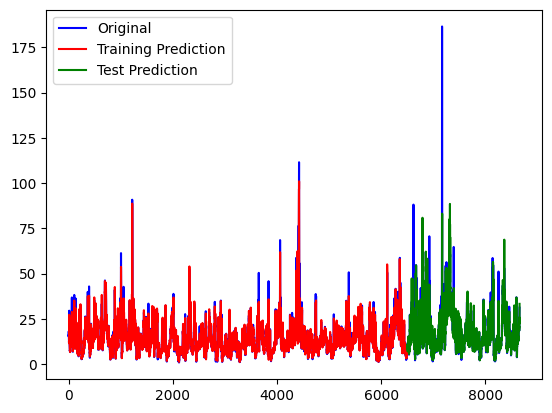

In [47]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b', label="Original")
plt.plot(train_plot, c='r', label="Training Prediction")
plt.plot(test_plot, c='g', label="Test Prediction")
plt.legend()
#plt.xlim(7250, 7750)
plt.show()